In [1]:
from functools import reduce

from cycler import cycler
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
#from scipy import stats as sstats
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt

import gspread
from google.oauth2.service_account import Credentials

In [2]:
%matplotlib inline
wmf.charting.set_mpl_style()

In [3]:
FILE = "metrics/metrics.tsv"
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

FILE_D =  "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(FILE_D, sep="\t", parse_dates=["month"]).set_index("month")

graph_end = metrics.index[-1]
graph_start = graph_end - relativedelta(months = 47)
prior_month = graph_end- relativedelta(months = 1)

# Data transformation

In [4]:
# Transform content flows into content stocks
def stock_to_flow(arr):
    return arr[-1] - arr[0]

flow_cols = [
    "net_new_content_pages", 
    "net_new_Wikipedia_articles", 
    "net_new_Commons_content_pages", 
    "net_new_Wikidata_entities"
]
stock_cols = [
    "content_pages", 
    "Wikipedia_articles", 
    "Commons_content_pages",
    "Wikidata_entities"
]

name_map = {flow_cols[i]: stock_cols[i] for i in range(len(stock_cols))}

stock_metrics = metrics[flow_cols].cumsum().rename(name_map, axis=1)

metrics = pd.concat([metrics, stock_metrics], axis=1)

# Show results
metrics.tail()

,active_editors,anonymous_edits,global_south_active_editors,global_south_edits,global_south_new_editor_retention,global_south_nonbot_edits,mobile-heavy_wiki_active_editors,mobile-heavy_wiki_edits,mobile-heavy_wiki_new_editor_retention,mobile-heavy_wiki_nonbot_edits,...,other_nonbot_edits,returning_active_editors,revert_rate,total_edits,uploads,wikidata_edits,content_pages,Wikipedia_articles,Commons_content_pages,Wikidata_entities
month,,,,,,,,,,,,,,,,,,,,,
2021-09-01,88925.0,2052391.0,24011.0,3010823.0,NaN,2498736.0,5164.0,997518.0,0.055482,586738.0,...,6045787.0,71883.0,0.054839,39502236.0,899197.0,15241328.0,288862123.0,58900635.0,78113119.0,96854836.0
2021-10-01,90041.0,2123708.0,23752.0,3271487.0,NaN,2484138.0,5157.0,908283.0,0.059102,550636.0,...,5959837.0,72931.0,0.054066,40870218.0,1494555.0,14084019.0,291277103.0,59204252.0,79462100.0,97351773.0
2021-11-01,89995.0,2018200.0,23066.0,3303526.0,NaN,2550849.0,5107.0,973932.0,0.056051,629947.0,...,5973130.0,73409.0,0.054219,39436215.0,586487.0,16358067.0,292737457.0,59492498.0,80005571.0,97772504.0
2021-12-01,89356.0,1995954.0,23172.0,3312507.0,NaN,2672058.0,5315.0,1060115.0,0.048249,659813.0,...,8267140.0,73315.0,0.053034,41299016.0,746046.0,16768078.0,294391137.0,59773599.0,80701637.0,98218598.0
2022-01-01,94400.0,2196791.0,24440.0,4380346.0,NaN,2692378.0,5588.0,2068915.0,0.049787,721691.0,...,11540342.0,76652.0,0.054356,46267521.0,781837.0,17365714.0,296061899.0,60105188.0,81405224.0,98596714.0


In [5]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2001-01-01 to 2022-01-01
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   active_editors                          254 non-null    float64
 1   anonymous_edits                         43 non-null     float64
 2   global_south_active_editors             41 non-null     float64
 3   global_south_edits                      41 non-null     float64
 4   global_south_new_editor_retention       34 non-null     float64
 5   global_south_nonbot_edits               41 non-null     float64
 6   mobile-heavy_wiki_active_editors        243 non-null    float64
 7   mobile-heavy_wiki_edits                 243 non-null    float64
 8   mobile-heavy_wiki_new_editor_retention  229 non-null    float64
 9   mobile-heavy_wiki_nonbot_edits          243 non-null    float64
 10  mobile_edits                            254

In [6]:
diversity_metrics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2018-01-01 to 2022-01-01
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   global_north_active_editors        29 non-null     float64
 1   global_north_edits                 29 non-null     float64
 2   global_north_net_new_content       29 non-null     float64
 3   global_north_new_editor_retention  20 non-null     float64
 4   global_north_nonbot_edits          29 non-null     float64
 5   global_north_wikidata_entities     29 non-null     float64
 6   global_south_active_editors        41 non-null     float64
 7   global_south_edits                 41 non-null     float64
 8   global_south_net_new_content       29 non-null     float64
 9   global_south_new_editor_retention  34 non-null     float64
 10  global_south_nonbot_edits          41 non-null     float64
 11  global_south_wikidata_entities     29 no

In [7]:
metrics_all = pd.concat([metrics, diversity_metrics], axis=1)
metrics_all  = metrics_all.loc[:,~metrics_all.columns.duplicated()]

# Report

In [8]:
report_order = [
     #Editors
    'active_editors',
        'new_active_editors',
        'returning_active_editors',
    'new_editor_retention',
    # Content
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
        'anonymous_edits',
        'non_anonymous_edits',
    #Diversity Content
    'global_north_net_new_content',
    'global_south_net_new_content',
    'global_north_edits',
    'global_south_edits',
    #Diversity Editors
    'global_north_active_editors',
    'global_south_active_editors',
    'global_north_new_editor_retention',
    'global_south_new_editor_retention'

]

In [9]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def calc_rpt(ser):   
    cur = ser[-1]
    
    try:
        yr_prev = ser[-13]
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
        
    try:
        cagr = (ser[-1] / ser[-48])**(1/4) - 1
    except IndexError:
        cagr = None
        
    
    res = [cur, yoy_change, cagr]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["value", "yoy_change", "4_yr_cagr"]
    )

def calc_prev_month_rpt(ser):   
    pm_cur = ser[-2]
    
    try:
        pm_yr_prev = ser[-14]
        pm_yoy_change = (pm_cur / pm_yr_prev) - 1
    except IndexError:
        pm_yoy_change = None
        
    try:
        pm_cagr = (ser[-2] / ser[-49])**(1/4) - 1
    except IndexError:
        pm_cagr = None
        
    
    pm_res = [pm_cur, pm_yoy_change, pm_cagr]
    return pd.Series(
        [fmt_num(n) for n in pm_res],
        index=["previous_M_value", "PM_yoy_change", "PM4_yr_cagr"]
    )

In [10]:
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
    .fillna("—")
)

,value,yoy_change,4_yr_cagr
active_editors,"94,400",-5.8%,4.6%
new_active_editors,"17,700",-16.9%,4.4%
returning_active_editors,"76,700",-2.8%,4.7%
new_editor_retention,6.2%,1.0%,4.5%
content_pages,"296,000,000",9.4%,13.5%
Wikipedia_articles,"60,100,000",6.1%,6.0%
Commons_content_pages,"81,400,000",18.2%,15.8%
Wikidata_entities,"98,600,000",5.4%,21.7%
net_new_content_pages,"1,670,000",-12.2%,-18.2%
net_new_Wikipedia_articles,"332,000",30.7%,19.5%


# Graphs

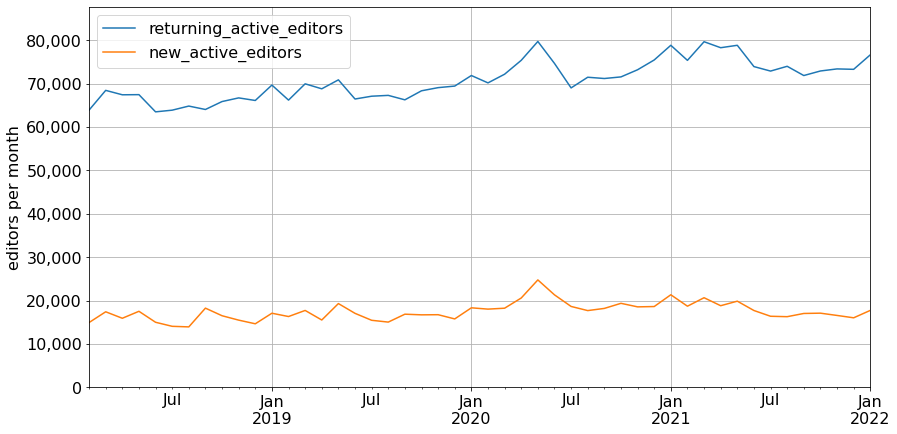

In [11]:
ax = metrics[["returning_active_editors", "new_active_editors"]][graph_start:graph_end].plot()
plt.gca().yaxis.set_major_formatter(comma_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("editors per month");

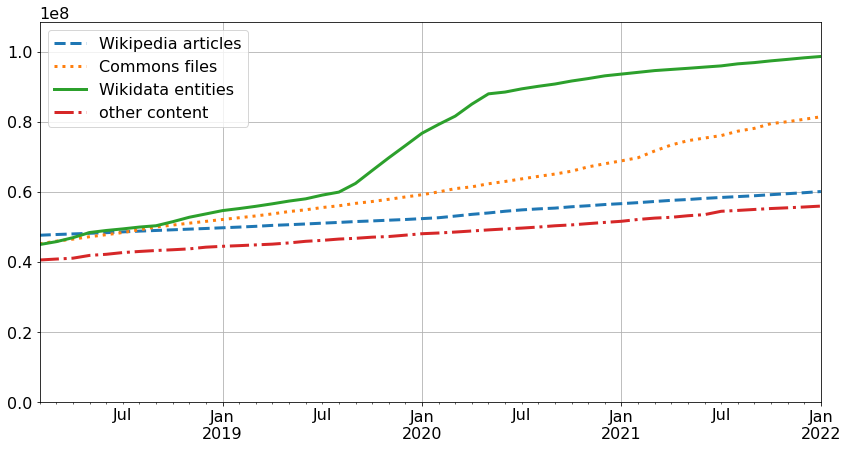

In [12]:
custom_cyc = cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['-', '--', ':', '-.'])
content_types = metrics[["Wikipedia_articles", "Commons_content_pages", "Wikidata_entities"]]
content_ser = [tup[1] for tup in content_types.iteritems()]

other_content = reduce(lambda x, y: x - y, content_ser, metrics["content_pages"]).rename("other_content")
content = pd.concat(
    [content_types, other_content], 
    axis=1
).rename(
    columns=lambda name: name.replace("_", " ")
).rename(
    columns={"Commons content pages": "Commons files"}
)

ax.set_prop_cycle(custom_cyc)
ax = content[graph_start:graph_end].plot(style=['--', ':', '-', '-.'], linewidth=3)

#ax.yaxis.set_major_formatter(M_fmt)
#--removed "ax.yaxis.set_major_formatter(M_fmt)" as a workaround to the error "M_str() takes 1 positional argument but 2 were given" that we encountered while running this notebok
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("");

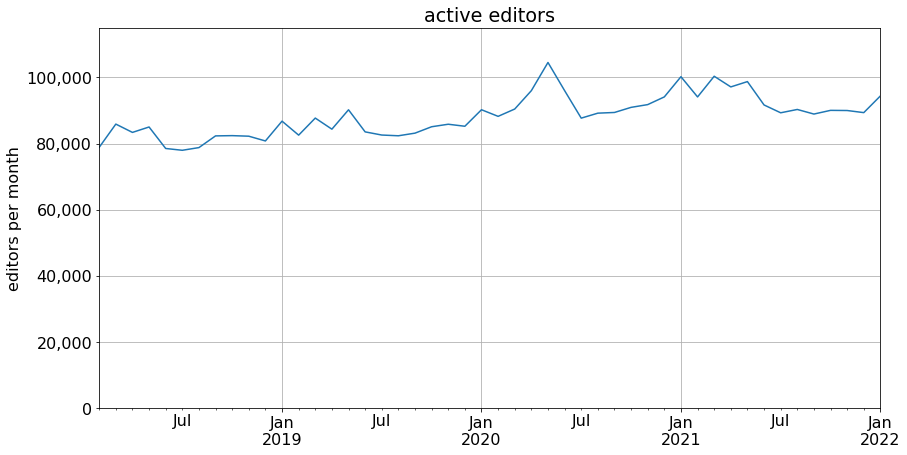

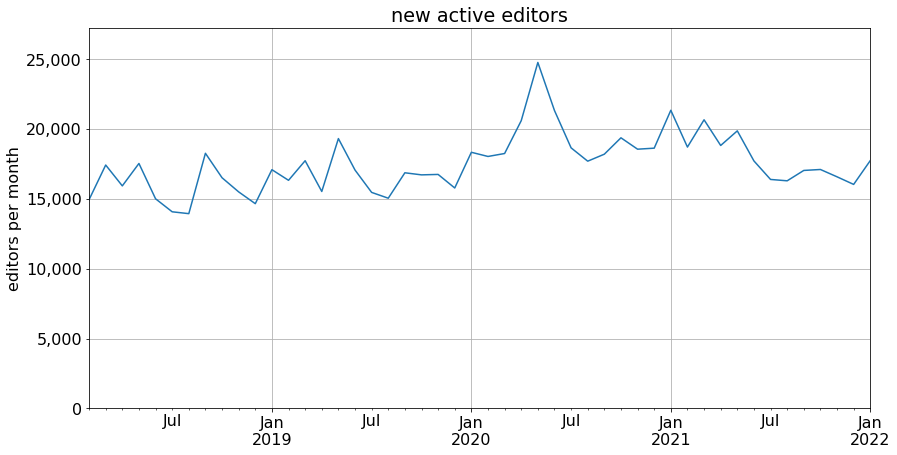

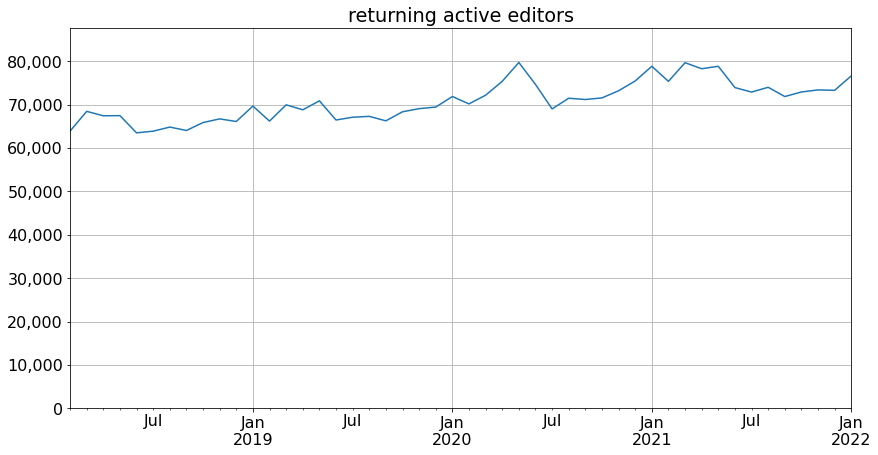

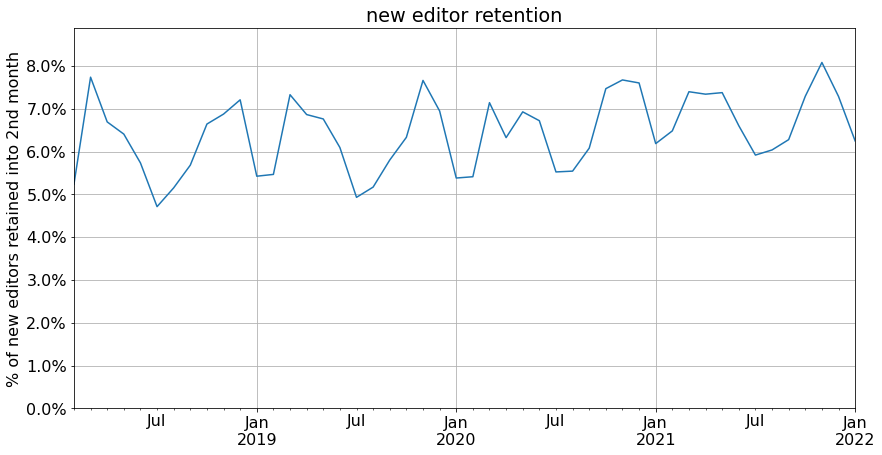

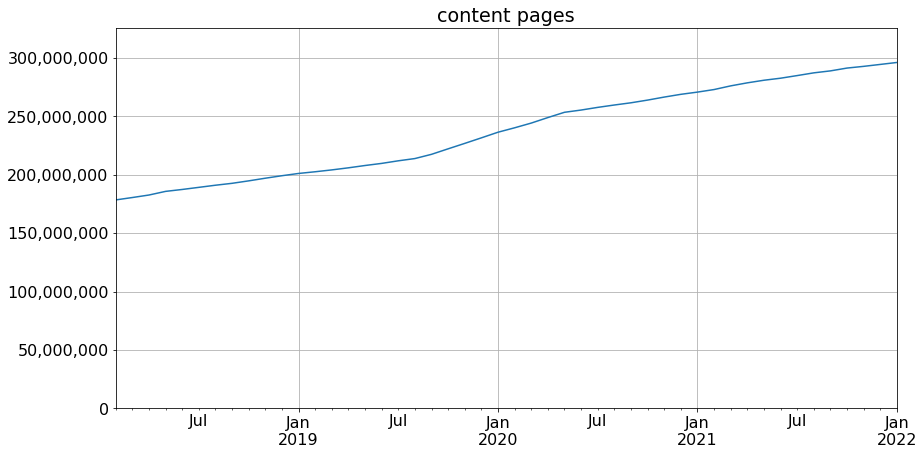

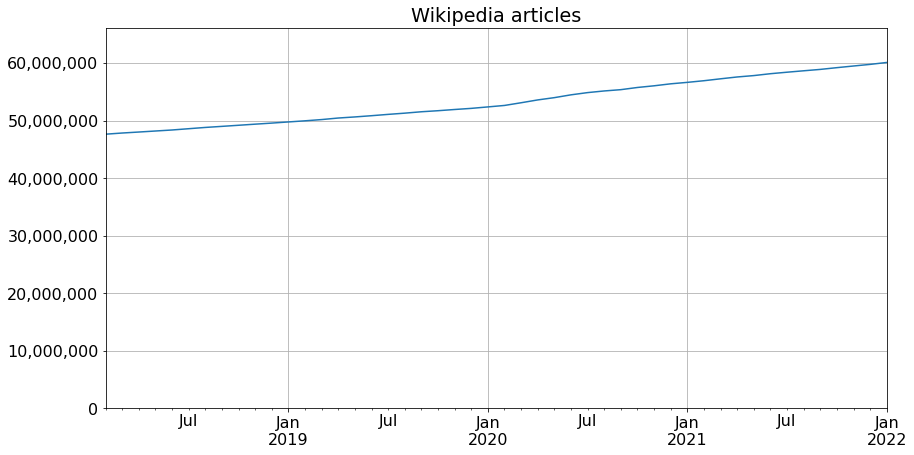

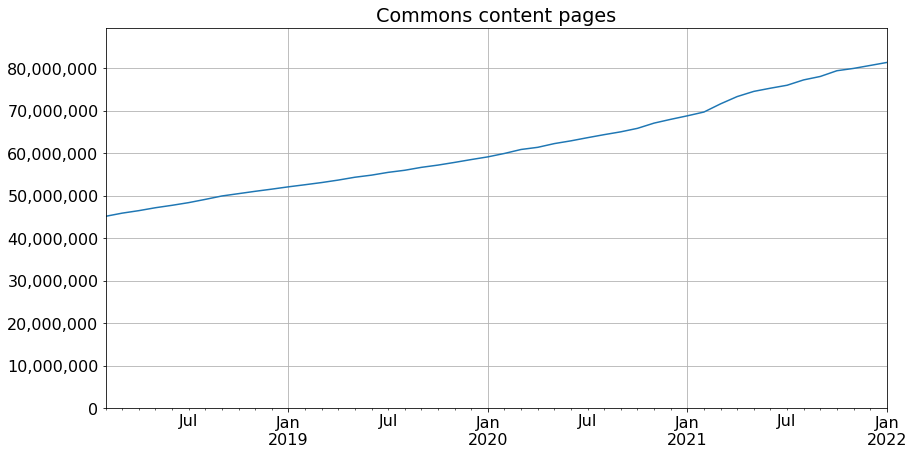

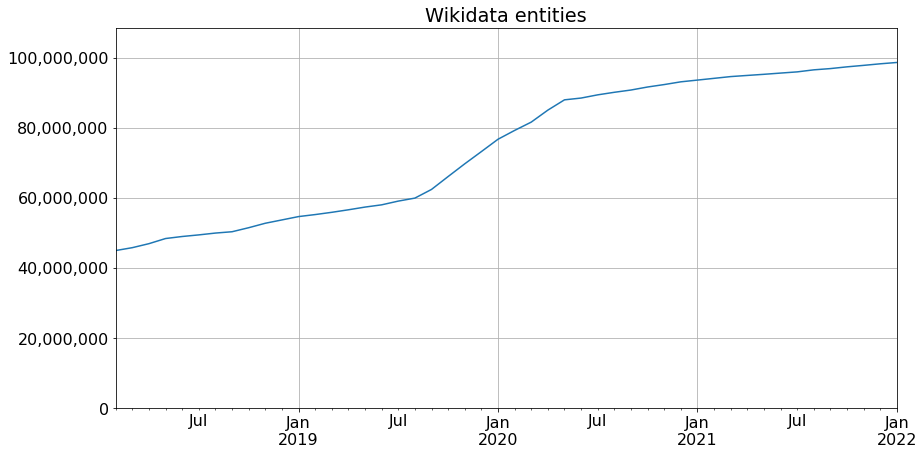

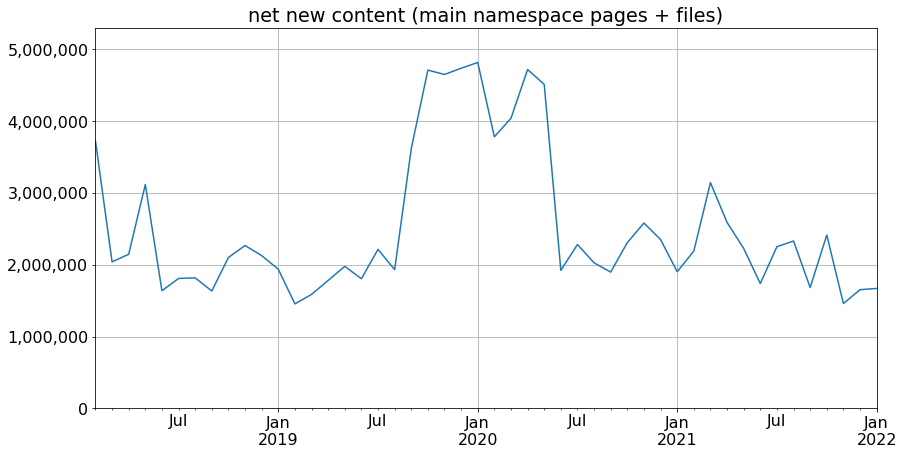

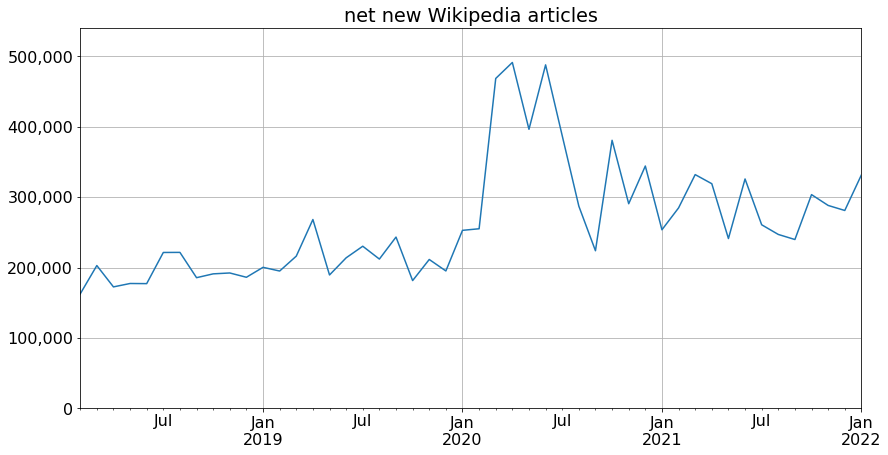

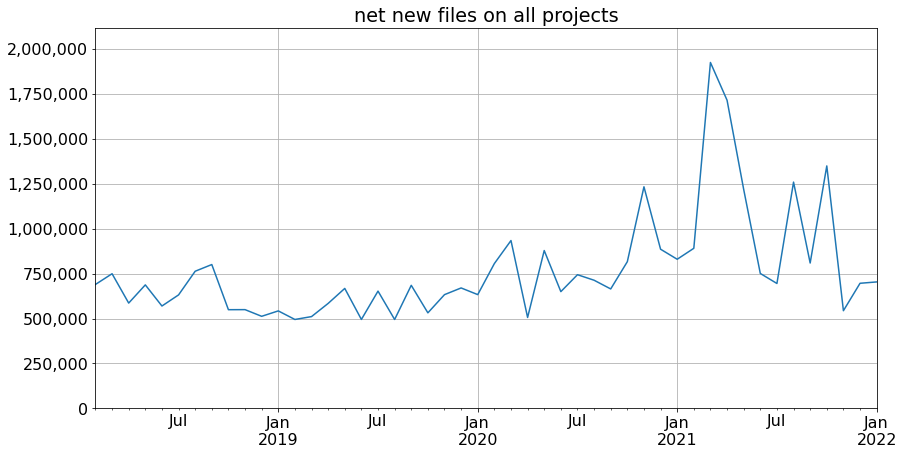

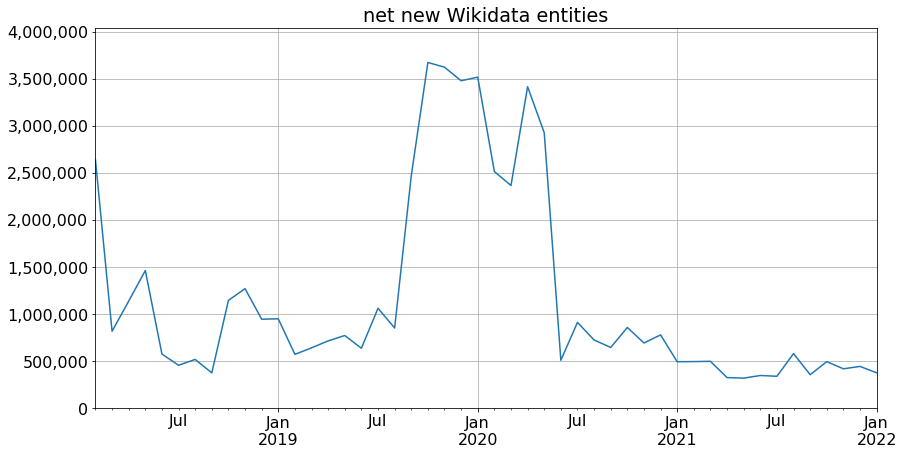

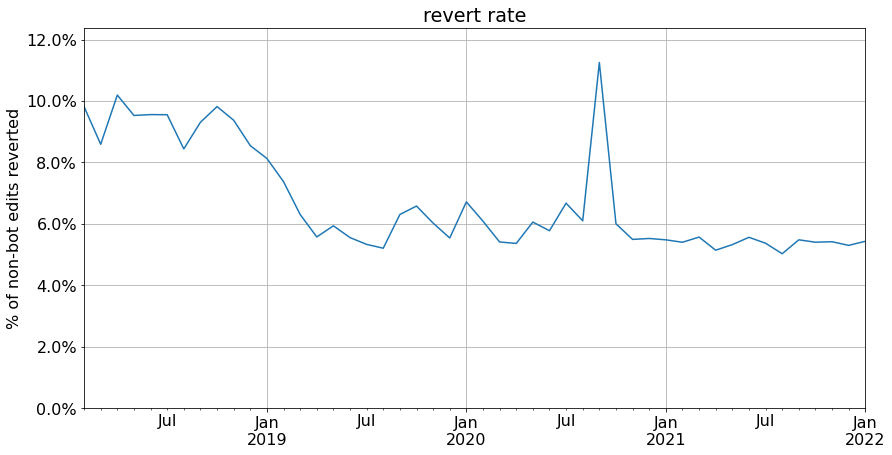

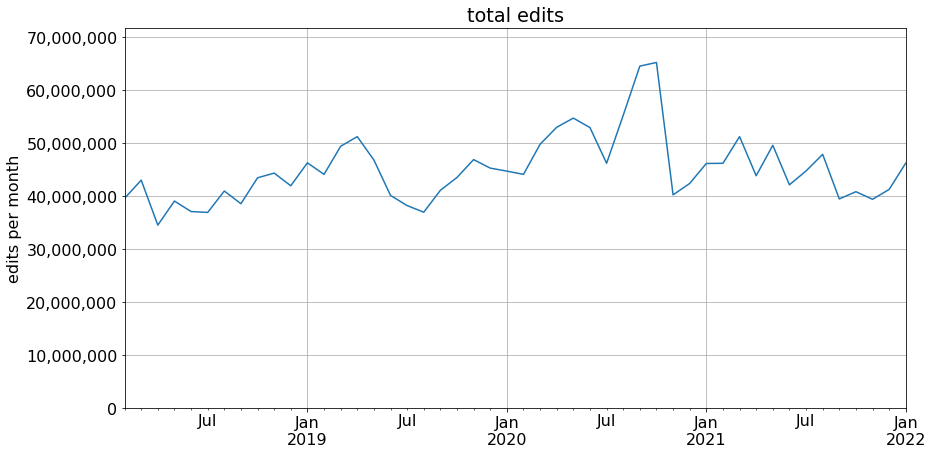

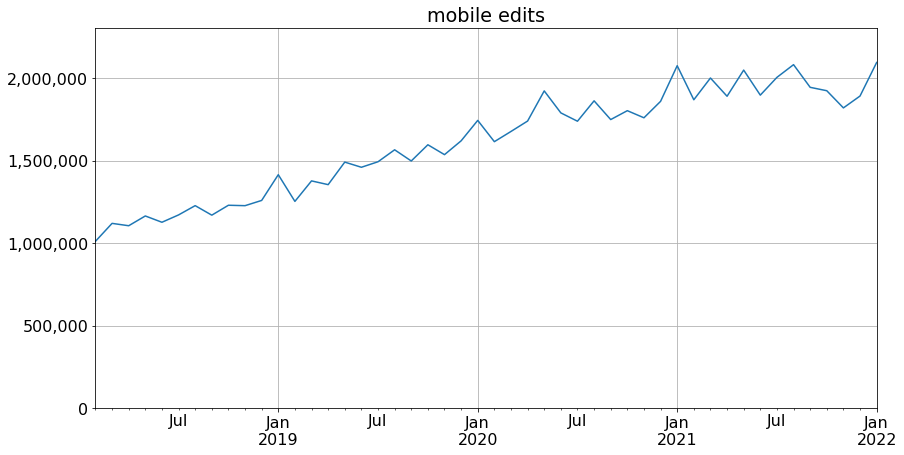

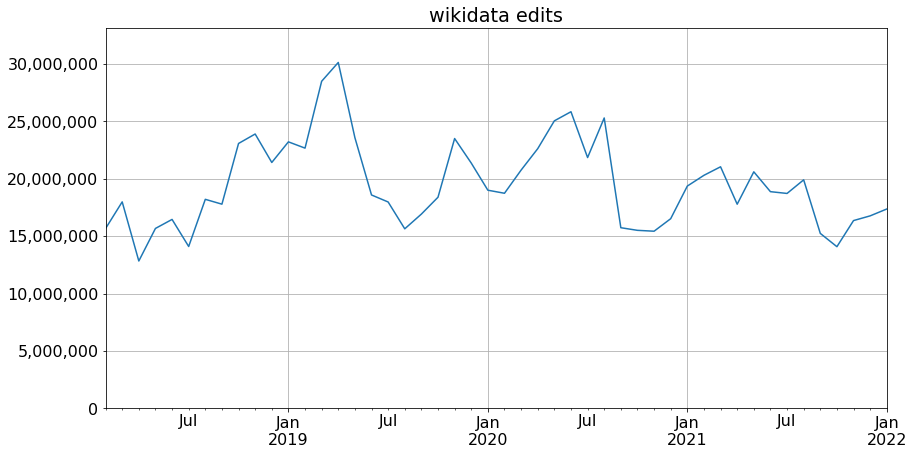

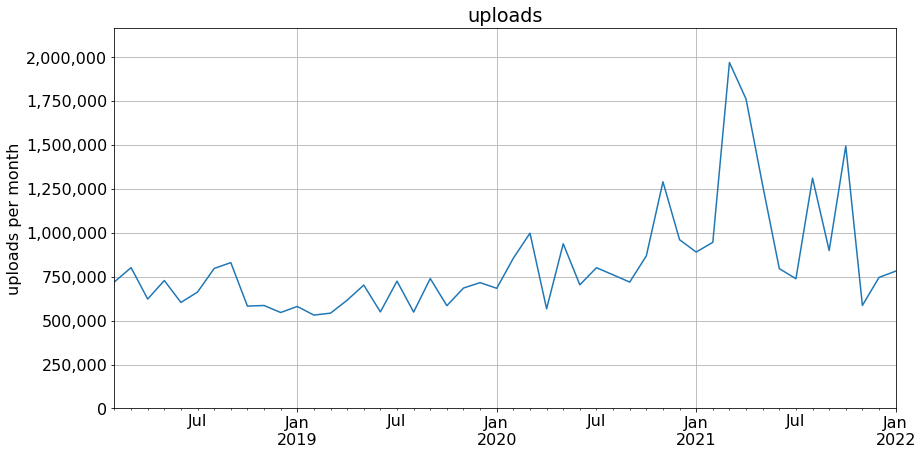

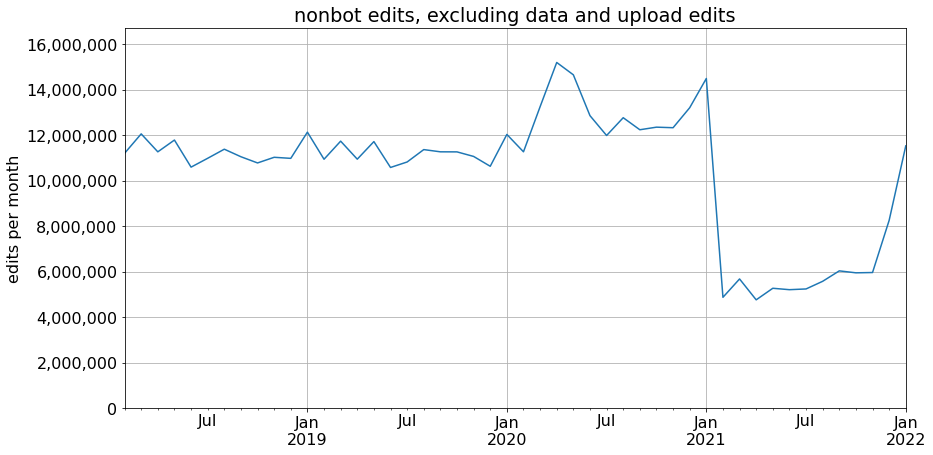

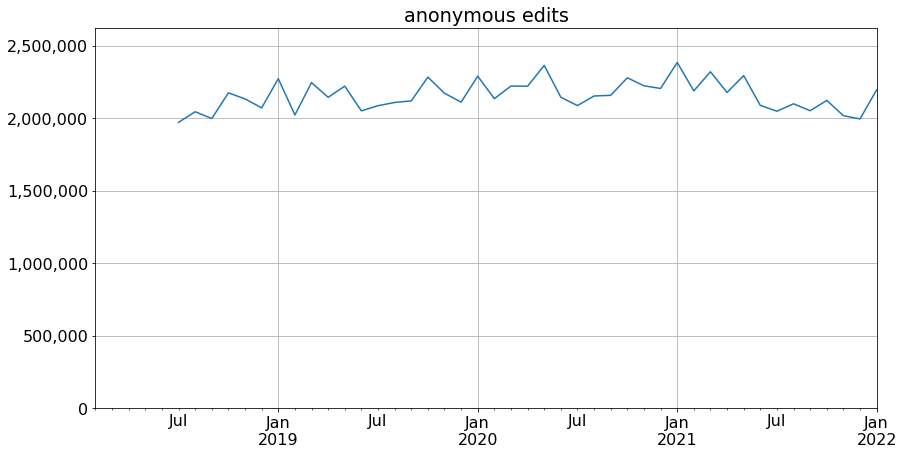

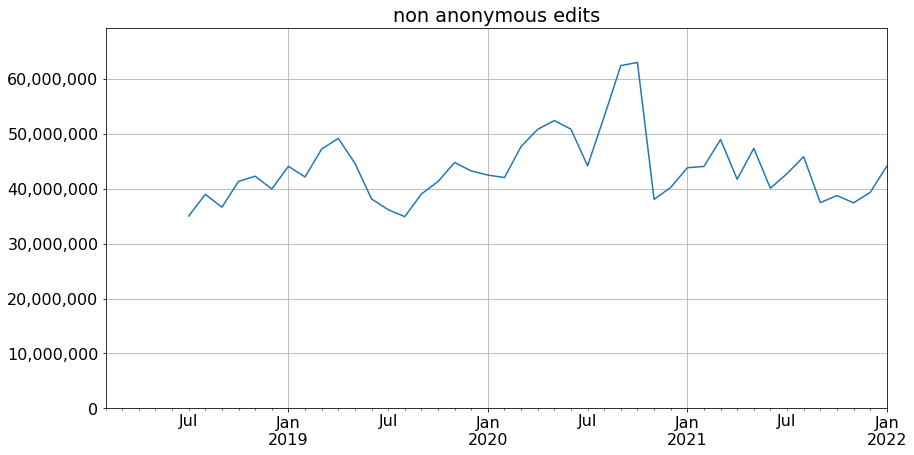

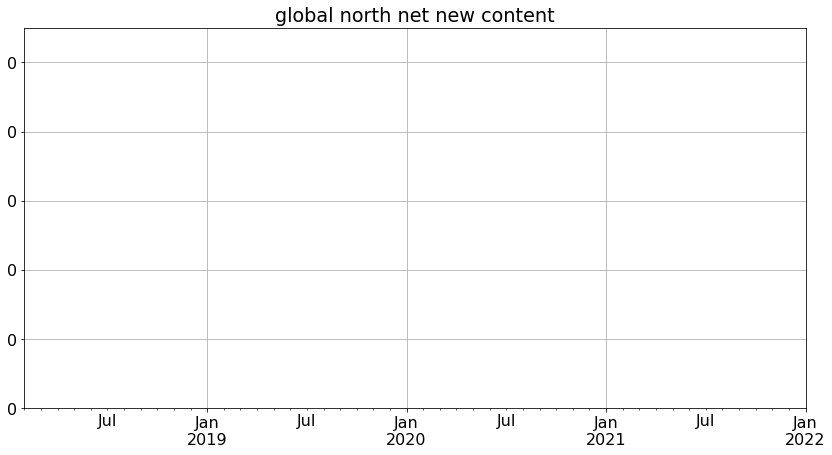

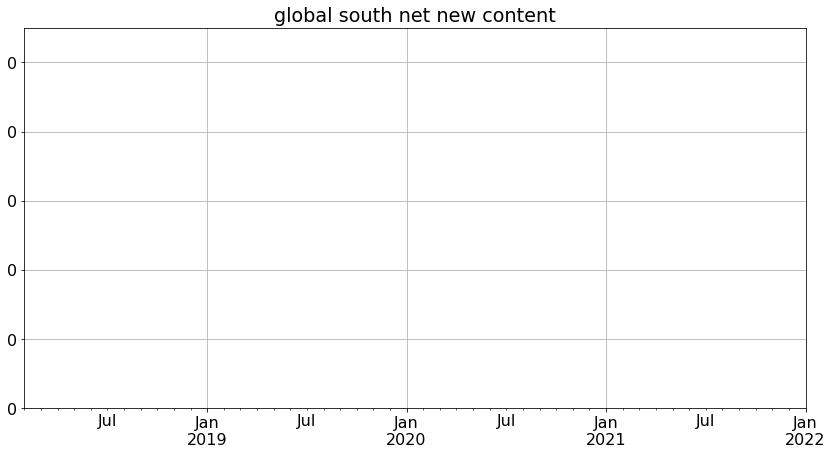

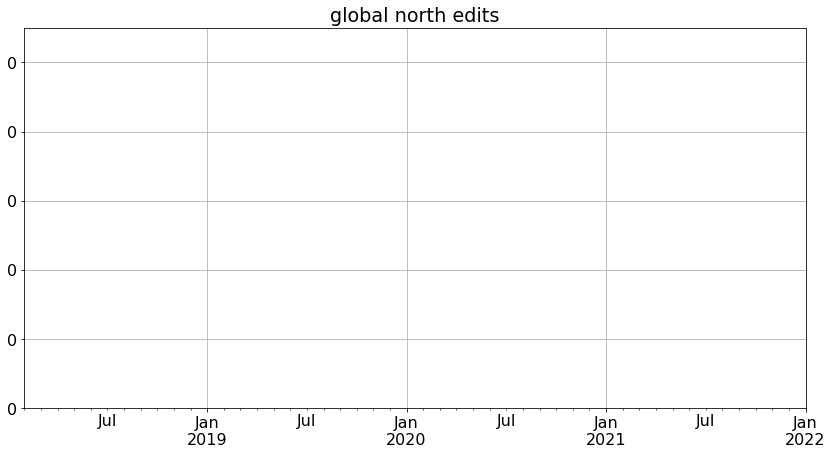

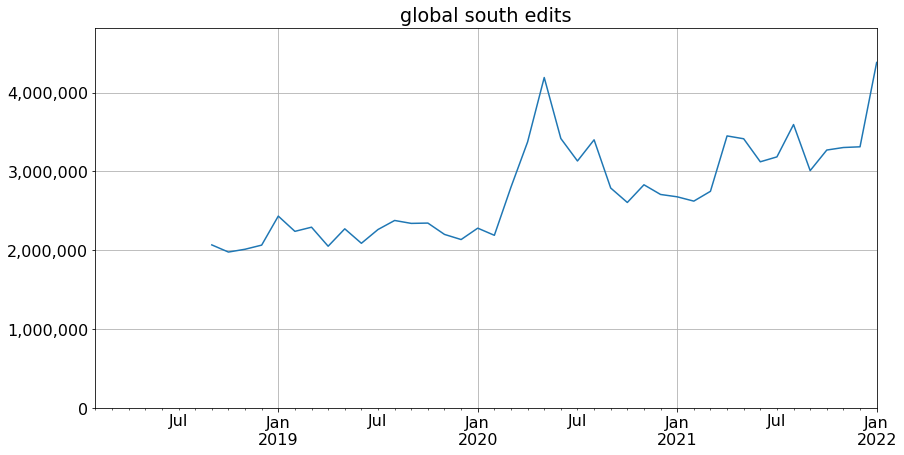

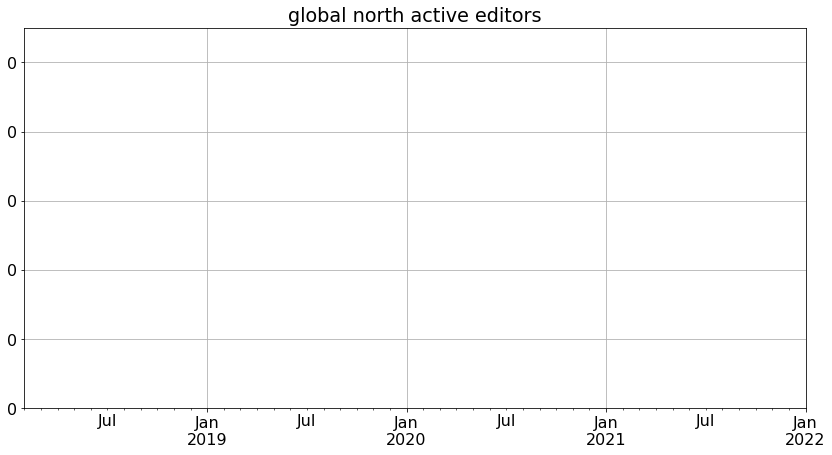

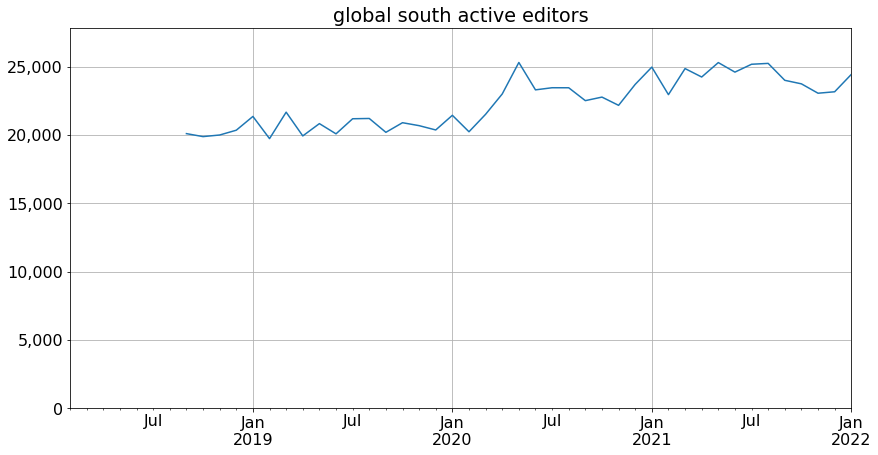

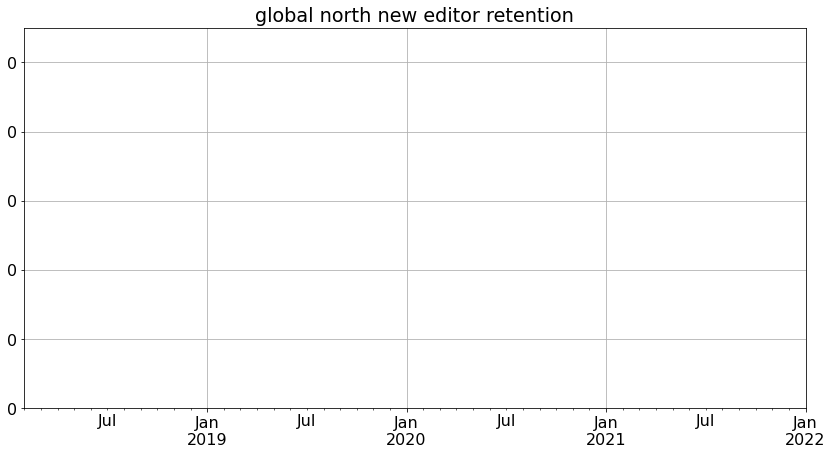

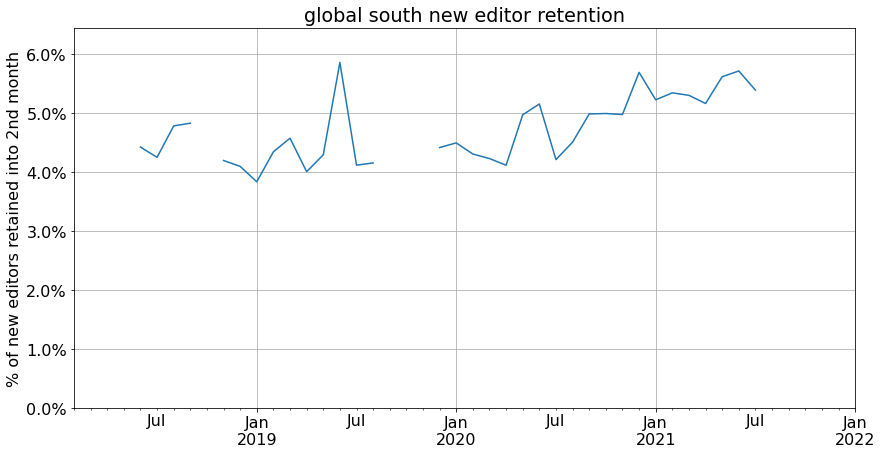

In [13]:
graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "content_pages": {
      #  "y_fmt": M_fmt,
        # removed M_Fmt from graph_cfg as a workaround for the error "M_str() takes 1 positional argument but 2 were given"
    },
    "Wikipedia_articles": {
       # "y_fmt": M_fmt,
    },
    "Wikidata_entities": {
       # "y_fmt": M_fmt,
    },
    "Commons_content_pages": {
       # "y_fmt": M_fmt,
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
       # "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
   
    "other_nonbot_edits": {
       # "y_fmt": M_fmt,
        "y_lab": "edits per month",
        "title": "nonbot edits, excluding data and upload edits"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    },
    "revert_rate": {
        "y_fmt": pct_fmt,
        "y_lab": "% of non-bot edits reverted"
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
      #  "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "net_new_content_pages": {
       # "y_fmt": M_fmt,
        "title": "net new content (main namespace pages + files)"
    },
    "net_new_Wikipedia_articles": {
    },
    "net_new_Commons_content_pages": {
        "title": "net new files on all projects"
    },
    "net_new_Wikidata_entities": {
    },
    "global_south_new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    }
}

for name, col in metrics.reindex(report_order, axis=1).iteritems():
    cfg = graph_cfg.get(name, {})
    plt.figure()
    
    col[graph_start:graph_end].plot()

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.xlabel("")
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
    
    y_top = plt.ylim()[1] * 1.1
    plt.ylim(bottom=0, top=y_top)
    plt.show()
    plt.close()

# Update Editors Google Sheet

In [14]:
FILE = "metrics/metrics.tsv"
all_metrics = pd.read_csv(FILE, sep="\t")


DIV_FILE = "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(DIV_FILE, sep="\t")

In [15]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('big-mender-274521-324384a764e2.json', scopes=scope)
gc = gspread.authorize(credentials)

In [16]:
all_metrics.iloc[-1,1:] = all_metrics.iloc[-1,1:].astype(float)
diversity_metrics.iloc[-1,1:] = diversity_metrics.iloc[-1,1:].astype(float)

In [17]:
@property
def sheet1(self):
    """Shortcut property for getting the first worksheet."""
    return self.get_worksheet(0)

In [18]:
wks1 = gc.open("editors").sheet1
new_metrics = all_metrics.iloc[-1,[0,1,2,11,12,13,14,15,16,17,18,19,20,21,22,23,24]].tolist()
wks1.append_row(new_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'metrics!A1:Q254',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'metrics!A255:Q255',
  'updatedRows': 1,
  'updatedColumns': 17,
  'updatedCells': 17}}

In [19]:
# To address NaN values that may cause errors when moving the values to sheets
#Replace all np.nan values with python's None
diversity_metrics = diversity_metrics.where(pd.notnull(diversity_metrics), None)

In [20]:
wks2 = gc.open("editors").get_worksheet(1)
div_metrics = diversity_metrics.iloc[-1].tolist()
wks2.append_row(div_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_global_market!A1:M49',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_global_market!A50:M50',
  'updatedRows': 1,
  'updatedColumns': 11,
  'updatedCells': 11}}

In [21]:
wks3 = gc.open("editors").get_worksheet(2)
mh_metrics = all_metrics.iloc[-1,[0,6,7,8,9]].tolist()
wks3.append_row(mh_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_mobile_heavy!A1:E252',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_mobile_heavy!A253:E253',
  'updatedRows': 1,
  'updatedColumns': 5,
  'updatedCells': 5}}

# Prep for Movement metric tables preparation - Editor sheet

In [22]:
mmtp_editor_report_order = [
     #Editors
    'active_editors',
    'new_active_editors',
    'returning_active_editors',
    'new_editor_retention',
]

In [23]:
#print the month to which this corresponds
print("Editors")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_editor_report_order)
    .fillna("—")
)

Editors
Month period: 2022-01


,value,yoy_change,4_yr_cagr
active_editors,"94,400",-5.8%,4.6%
new_active_editors,"17,700",-16.9%,4.4%
returning_active_editors,"76,700",-2.8%,4.7%
new_editor_retention,6.2%,1.0%,4.5%


In [24]:
#print the month to which this corresponds
print("Editors")
print("Month period:", prior_month.strftime("%Y-%m"))

(
    metrics_all
    .apply(calc_prev_month_rpt)
    .transpose()
    .reindex(mmtp_editor_report_order)
    .fillna("—")
)

Editors
Month period: 2021-12


,previous_M_value,PM_yoy_change,PM4_yr_cagr
active_editors,"89,400",-5.1%,1.4%
new_active_editors,"16,000",-13.9%,-0.9%
returning_active_editors,"73,300",-2.9%,2.0%
new_editor_retention,7.3%,-4.2%,7.8%


# Prep for Movement metric tables preparation - Diversity sheet, Editors section

In [25]:
mmtp_diversity_editor_report_order = [
    #Editors
    'active_editors',
    #Diversity Editors
    'global_north_active_editors',       #— Established Markets
    'global_south_active_editors',       #— Emerging Markets
    'new_editor_retention',
    'global_north_new_editor_retention', #— Established Markets
    'global_south_new_editor_retention'  #— Emerging Markets
]

In [26]:
#print the month to which this corresponds
print("Editors - diversity")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_diversity_editor_report_order)
    .fillna("—")
)

Editors - diversity
Month period: 2022-01


,value,yoy_change,4_yr_cagr
active_editors,"94,400",-5.8%,4.6%
global_north_active_editors,"76,300",-5.2%,—
global_south_active_editors,"24,400",-2.1%,—
new_editor_retention,6.2%,1.0%,4.5%
global_north_new_editor_retention,—,—,—
global_south_new_editor_retention,—,—,—


In [27]:
#print the month to which this corresponds
print("Editors - diversity")
print("Month period:", prior_month.strftime("%Y-%m"))

(
    metrics_all
    .apply(calc_prev_month_rpt)
    .transpose()
    .reindex(mmtp_diversity_editor_report_order)
    .fillna("—")
)

Editors - diversity
Month period: 2021-12


,previous_M_value,PM_yoy_change,PM4_yr_cagr
active_editors,"89,400",-5.1%,1.4%
global_north_active_editors,"71,300",-6.0%,—
global_south_active_editors,"23,200",-2.3%,—
new_editor_retention,7.3%,-4.2%,7.8%
global_north_new_editor_retention,—,—,—
global_south_new_editor_retention,—,—,—


# Prep for Movement metric tables preparation - Content sheet

In [28]:
mmtp_content_report_order = [
    # Content
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
]

In [29]:
#print the month to which this corresponds
print("Content")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_content_report_order)
    .fillna("—")
)

Content
Month period: 2022-01


,value,yoy_change,4_yr_cagr
content_pages,"296,000,000",9.4%,13.5%
Wikipedia_articles,"60,100,000",6.1%,6.0%
Commons_content_pages,"81,400,000",18.2%,15.8%
Wikidata_entities,"98,600,000",5.4%,21.7%
net_new_content_pages,"1,670,000",-12.2%,-18.2%
net_new_Wikipedia_articles,"332,000",30.7%,19.5%
net_new_Commons_content_pages,"704,000",-15.2%,0.5%
net_new_Wikidata_entities,"378,000",-23.8%,-38.5%
revert_rate,5.4%,-0.9%,-13.7%
total_edits,"46,300,000",0.2%,4.0%


# Prep for Movement metric tables preparation - Diversity sheet, content section

In [30]:
mmtp_content_diversity_report_order = [
    # Content
    'content_pages',  #total content
    'net_new_content_pages',
    #Diversity Content
    'global_north_net_new_content',
    'global_south_net_new_content',
    'total_edits',
    'global_north_edits',
    'global_south_edits',
    'anonymous_edits',
]

In [31]:
#print the month to which this corresponds
print("Content")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_content_diversity_report_order)
    .fillna("—")
)

Content
Month period: 2022-01


,value,yoy_change,4_yr_cagr
content_pages,"296,000,000",9.4%,13.5%
net_new_content_pages,"1,670,000",-12.2%,-18.2%
global_north_net_new_content,"1,190,000",-23.9%,—
global_south_net_new_content,"259,000",-13.5%,—
total_edits,"46,300,000",0.2%,4.0%
global_north_edits,"22,000,000",-12.2%,—
global_south_edits,"4,380,000",63.5%,—
anonymous_edits,"2,200,000",-7.9%,—


In [32]:
#YoY Non-Wikidata net new content
#Year-over-year Growth = [(This Year – Last Year) / Last Year] X 100